In [2]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import base64
from io import BytesIO
from PIL import Image
from pydub import AudioSegment
from pydub.playback import play
import speech_recognition as sr  

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

system_message = "You are a helpful assistant for a weather forecast called WeatherAI."
system_message += " Give short, courteous answers, no more than 1 sentence."
system_message += " Always be accurate. If you don't know the answer, say so."

weather_forecast = {"copenhagen": "-3°", "paris": "2°", "stockholm": "-5°", "oslo": "-10°","bali": "27°"}

def get_weather_forecasting(weather_city):
    print(f"Tool get_weather_forecast called for {weather_city}")
    city = weather_city.lower()
    return weather_forecast.get(city, "Unknown")


weather_function = {
    "name": "get_weather_forecasting",
    "description": "Get the weather degree of the city. Call this whenever you need to know the weather degree.",
    "parameters": {
        "type": "object",
        "properties": {
            "weather_city": {
                "type": "string",
                "description": "The city that the customer wants to learn the temperature of"
            },
        },
        "required": ["weather_city"],
        "additionalProperties": False
    }
}


tools = [{"type": "function", "function": weather_function}]

def gradio_chat(message, history):
    if history is None:  
        history = [] 
    print(f"History at the beginning: {history}")  

    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    print(f"Messages to OpenAI: {messages}") 

    try:
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
        print(f"Response from OpenAI: {response}") 
    except Exception as e:
        print(f"Error with OpenAI request: {e}")
        return "Sorry, I couldn't process your request.", None  
    image = None
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)  
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]
    
    talker(reply)  

    return history, image  

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('weather_city')  
    temperature = get_weather_forecasting(city)
    response = {
        "role": "tool",
        "content": json.dumps({"weather_city": city, "temperature": temperature}),
        "tool_call_id": tool_call.id
    }
    return response, city  


def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a weather in {city} showing the weather for example if its cold show weather in that style or if its hot show in that style and everything unique about {city}, in a realistic style",
        size="1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_data))
    return image  

def speech_to_text():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("Please say something...")
        audio = recognizer.listen(source)
        try:
            text = recognizer.recognize_google(audio)
            print(f"You said: {text}")
            return text
        except sr.UnknownValueError:
            print("Sorry, I could not understand that.")
            return "Sorry, I could not understand that."
        except sr.RequestError:
            print("Sorry, I'm having trouble with the speech recognition service.")
            return "Sorry, I couldn't process that."


def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")
    with gr.Row():
        speech_button = gr.Button("Speak to Assistant")

    def do_entry(message, history):
        if history is None:
            history = []  
        history += [{"role": "user", "content": message}]
        return "", history

    def do_speech(message, history):
        spoken_message = speech_to_text() 
        if history is None:
            history = [] 
        history += [{"role": "user", "content": spoken_message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        gradio_chat, inputs=[entry, chatbot], outputs=[chatbot, image_output]
    )

    speech_button.click(do_speech, inputs=[speech_button, chatbot], outputs=[speech_button, chatbot]).then(
        gradio_chat, inputs=[speech_button, chatbot], outputs=[chatbot, image_output]
    )

    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(share=True)


OpenAI API Key exists and begins sk-proj-
* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://ca1c749095ef5f989f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


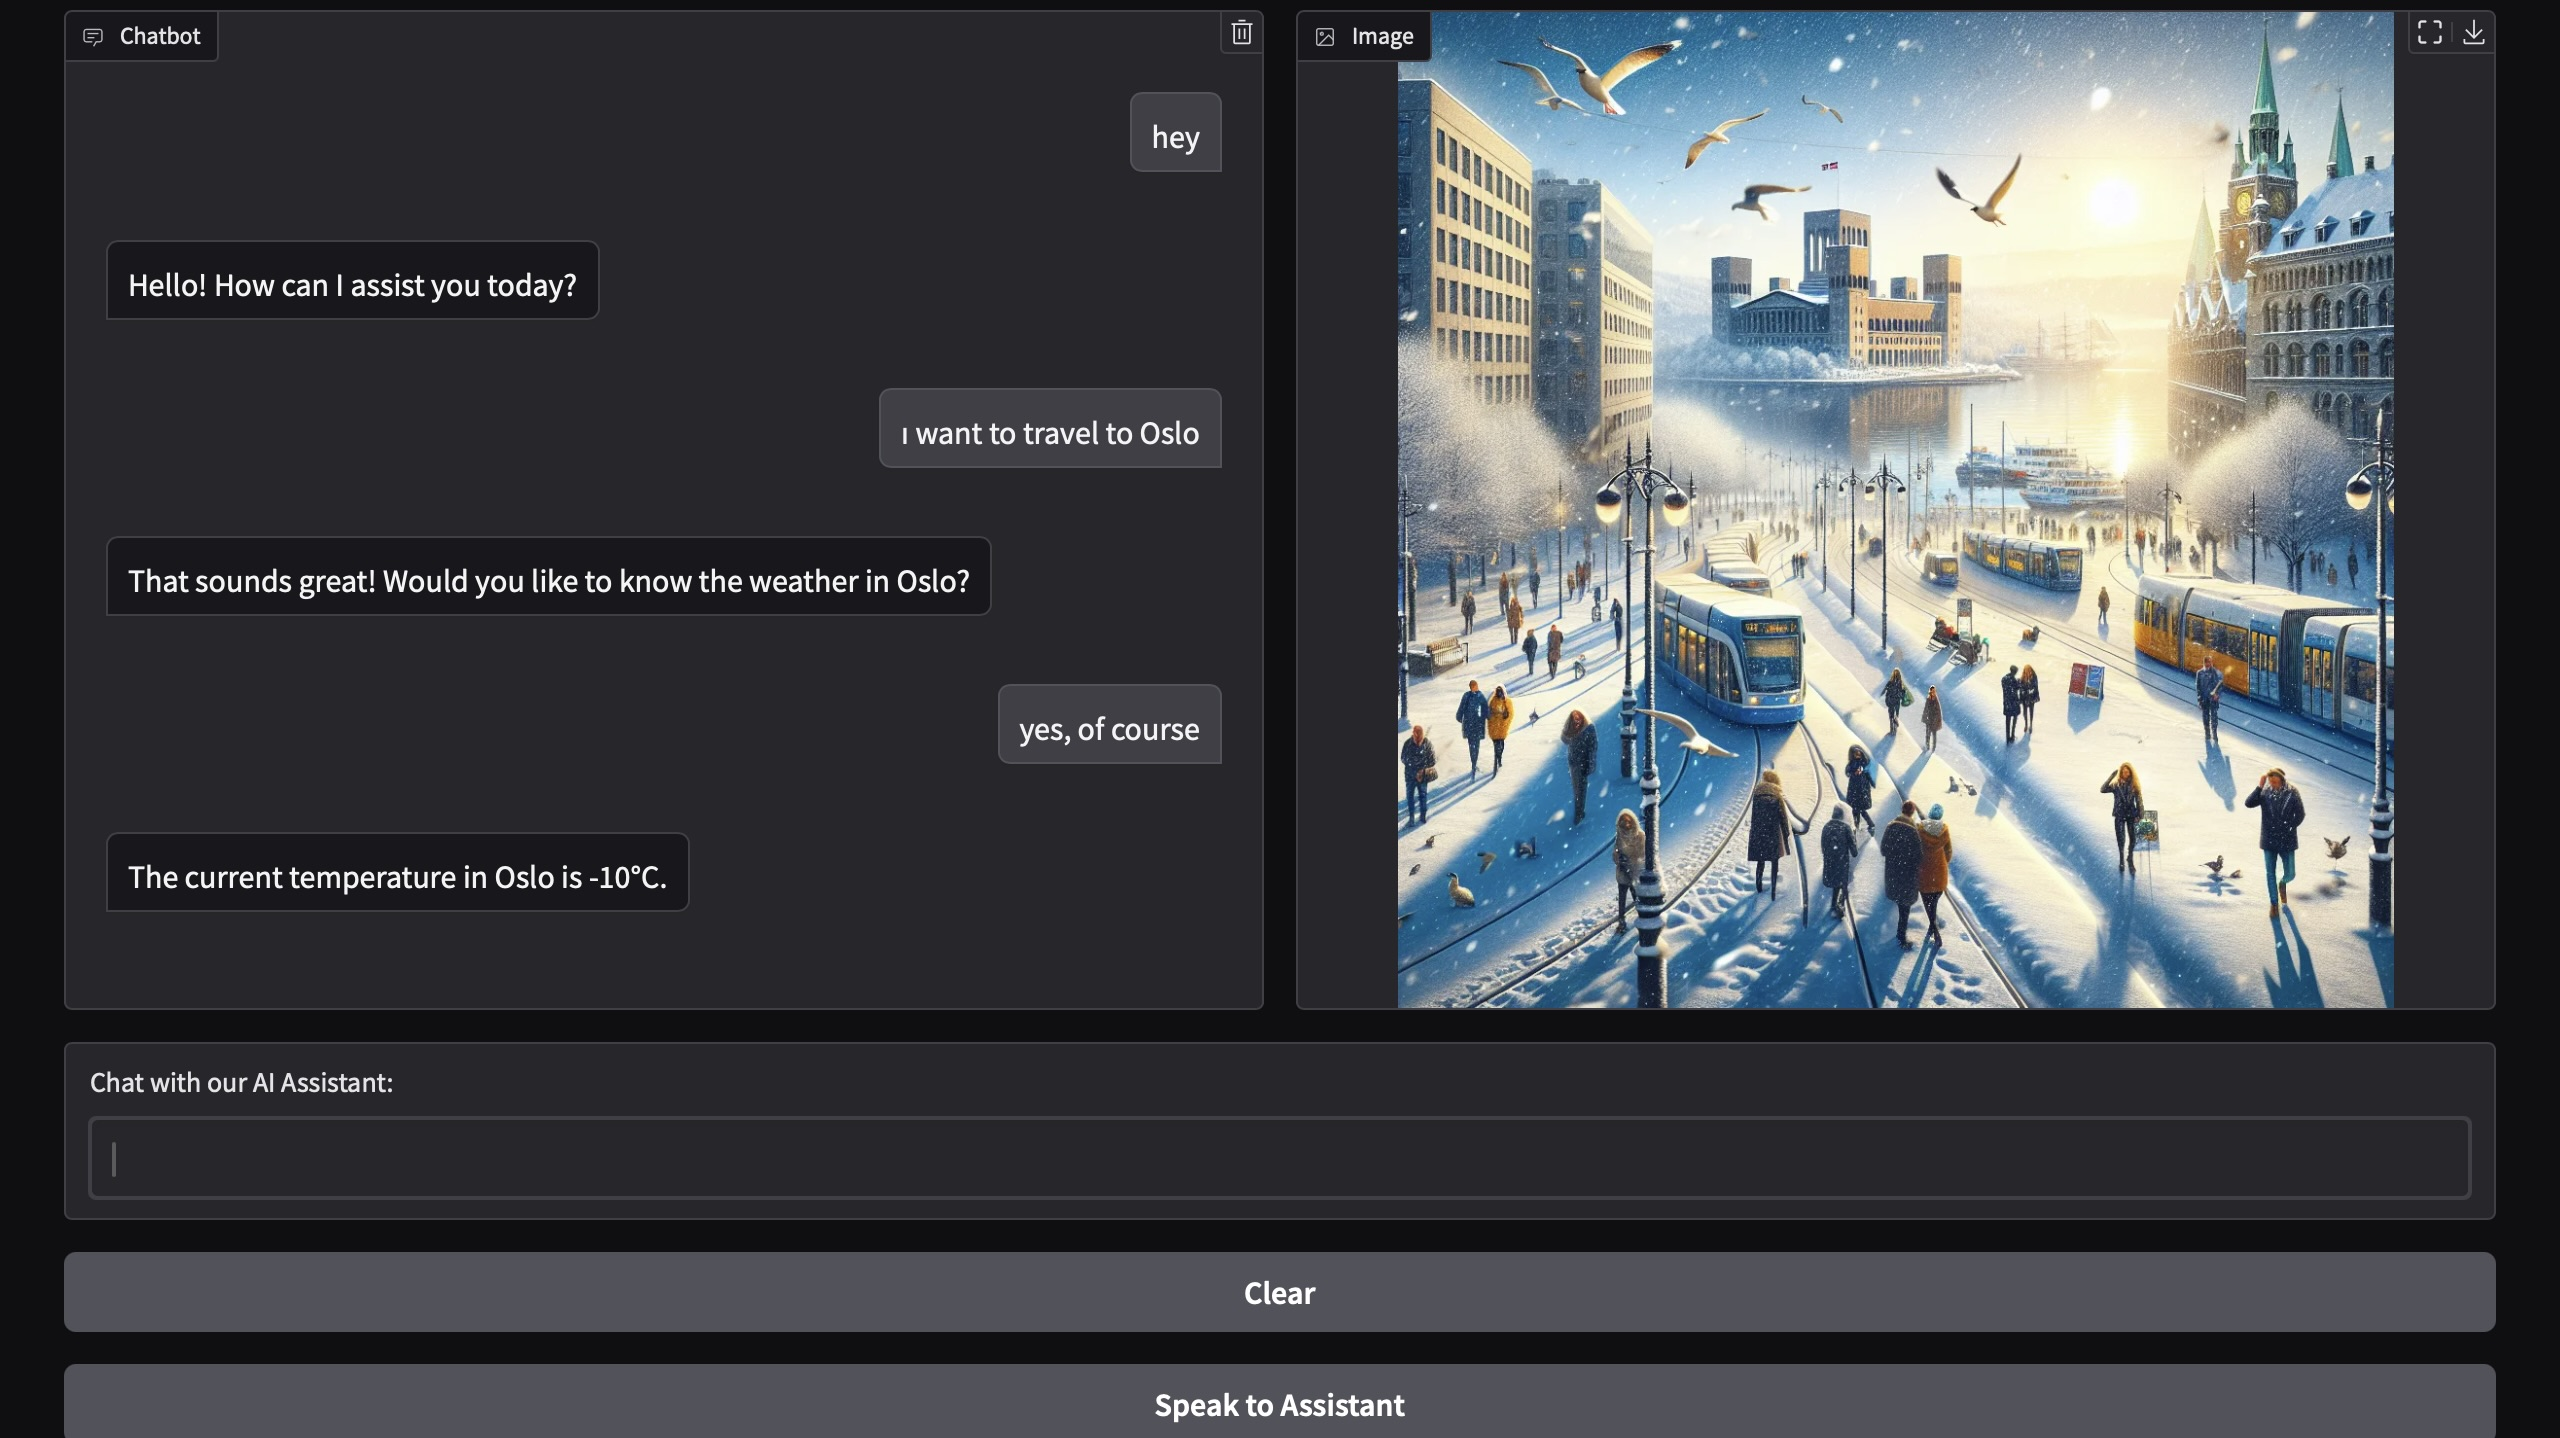